# Analysis of the Global Scenario of Chess
## I. Executive Summary
This notebook analyzes the global scenarios in the field of playing chess; comparison of winning percentage of players, games played, and other demographics between each country all over the world. Even though chess is an individual game, the performance per country also provides significant insights. It then focuses on the best country to provide understanding and conclusion on how this country dominated the world of chess.

We analyze this by using data from **Chessgames.com**. This site maintains a large database of chess games which claims to be the biggest and popular online chess dataset and community. We used `BeautifulSoup` to scrape the data from two of its primary webpages having different outputs for different player identification numbers, which are, Player Biography and Player Game Database. After scraping, data preprocessing techniques such as restructuring, cleaning and text extraction, which was primarily conducted using `Pandas` and `RegEx`. Finally, the clean and manipulated data was stored in `SQLite3` Database. 

The data stored in SQLite3 were made into need-based DataFrames and performed Exploratory Data Analysis, primarily to understand the nature of data from statistical point of view. To understand the global scenarios, we conducted interactive geospatial analysis using `Folium`, that provides an intuition on dominating countries. This provided insights on the dominating country and in the end, determine the characteristics of that country's players and provides a concise overview on how Russians are currently dominating in terms of the amount of Chess Grandmasters based on the current dataset. 

### Problem Statement
Determine the dominating country in the world of chess, provide insights on its players, to understand why they became the strongest chess nation.

### Highlights of Result

1. Average winning rate of the nation is 37%
2. Most of the prominent players belong to the northern hemisphere
3. There are more Male prominent players in Chess than Female Prominent Players

## II. Data Source Description
Data used in this report are from the website http://www.chessgames.com/, an online database of chess games wherein you can find data on almost all professional and non-professional chess players in the world, as well as information on their games.

<img src="chessgamescom.JPG" width="500" />

For this report, we obtained data on:
* **Player**
    * Player ID - identification of player in the online database
    * Full name
    * Country of origin
    * Gender


* **Games played by each player**
    * Game ID - identification of the game in the online database
    * Position - if the player played first (white) or second (black)
    * Opponent - name of the opponent
    * Result - did the player win or lose or had a draw
    * Moves - total number of moves taken by the game
    * Year
    * Event - tournament name
    * Opening - opening move of white player

## III. Data Preprocessing
### Extraction and Loading of Data

#### Web Scraping    
Data from http://www.chessgames.com/ was extracted (commonly known as *web scraping*) using **BeautifulSoup** package. BeautifulSoup is a Python library for parsing HTML and XML files. It creates a parse tree for parsed pages that can be used to extract data from HTML.

*Disclaimer*: This report conducted the analysis on a sample of the total players in Chessgames.com. Insights are only applicable on the said sample. The reporters wish to scale the study to the population but was not able to do so due to time and resource constraints. But note that this study is scalable, by adding the remaining data to the database, and the results, insights, and highlights may vary.

#### Storing in a database
Extracted data was loaded to tables in a **SQLite** database named <*chessgames.db*>. SQLite is a C library that can be used in Python that provides a lightweight disk-based database that doesn’t require a separate server process.

### 1. Loading Preliminaries

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import re
import json
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
import folium
from typing import Union
import altair as alt
import geopandas as gpd
import folium
import geopandas as gpd
import pandas as pd
import fiona
import requests
import json
import numpy as np
from shapely.geometry import Point
from branca.colormap import linear
import os
from collections import Counter

# Use proxy and headers for safe web scraping
os.environ['HTTP_PROXY'] = 'http://13.115.147.132:8080'
pd.options.mode.chained_assignment = None
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36'
    '(KHTML, like Gecko) Chrome/74.0.3729.147 Safari/537.36'}

### 2. Create SQLite connection
We created 3 tables in the SQLite database with the schema shown in the figure below
* **Playertemp**

* **Player**

* **Playerdb**

<img src="schema.png" width="400" />

### 3. Extracting Player ID and Last Name (Web Scraping)

In [3]:
# Getting html data from ChessGames:
source = requests.get('http://www.chessgames.com/', headers=headers).text
soup = BeautifulSoup(source, 'lxml')

In [4]:
# Fetching player id tags
tag = []
for select in soup.findAll("select", {"name": 'pid'}):
    for option in select.contents:
        tag.append(option)
pid = [str(i) for i in list(set(tag))]

In [5]:
# Player IDs and Player name extraction
playerid = []
for i in pid:
    playerid.append(re.findall(r'(\d.*\d).(?:>)(.*)', i))
plid = [i for sublist in playerid for i in sublist]

In [6]:
# Adding them into SQLite db under table Playertemp
for item in plid:
    conn.execute('''INSERT OR IGNORE INTO Playertemp (PID, LName) 
        VALUES ( ?, ? )''', item)
conn.commit()

In [7]:
# Making a list of all Player IDs (PID) to be used in the next steps
playerid = pd.DataFrame(conn.execute('''
    SELECT PID,LName
    FROM Playertemp'''), columns=['id', 'name'])
pids = playerid['id'].tolist()

### 4. Extracting Full Name and Country of Origin (Web Scraping)

In [8]:
# Name and origin Country
pido = []
names = []
others = []
for pid in playerid['id']:
    pido.append(pid)
    playerUrl = requests.get(
        'http://www.chessgames.com/perl/chessplayer?pid='+str(pid), headers=headers).text
    playerUrlSoup = BeautifulSoup(playerUrl, 'lxml')
    for select in playerUrlSoup.findAll("td", {"background": '/chessimages/highlight_stripes.gif', "bgcolor": "#663300"}):
        for name in select.findAll('b'):
            names.append(name.text)
        for other in select.findAll('font', {'size': '-2'}):
            if other.text == 'PRONUNCIATION:':
                pass
            else:
                if len(re.findall(r'(?:.*[)]).(.*)\s[(].*', other.text)) == 0:
                    if len(re.findall(r'(?:.*[)]).(.*).*', other.text)) == 1:
                        text = re.findall(r'(?:.*[)]).(.*).*', other.text)[0]
                        others.append(text)
                    else:
                        others.append('Unknown')
                else:
                    text = re.findall(r'(?:.*[)]).(.*)\s[(].*', other.text)[0]
                    others.append(text)

In [9]:
# Storing scraped data in Pandas DataFrame
x = [(pido[i],names[i],others[i]) for i in range(len(playerid))]
xupdated = [(x[i][0],x[i][1].title(),x[i][2]) for i in range(len(playerid))]
origindb = pd.DataFrame(xupdated,columns=['id','Name','Origin'])

### 5. Extracting Gender (Web Scraping)
This is not directly given on the website. For us to determine the gender, we used **Regex** (Regular Expression) to check if the description of the player has the words *he*, *him* for males OR *she*, *her* for females.

In [10]:
# Scraping Gender Data
from collections import Counter
pidg = []
gender = []
for pid in playerid['id']:
    pidg.append(pid)
    others = []
    playerUrl = requests.get(
        'http://www.chessgames.com/perl/chessplayer?pid='+str(pid), headers=headers).text
    playerUrlSoup = BeautifulSoup(playerUrl, 'lxml')
    for select in playerUrlSoup.findAll("td", {"colspan": "2"}):
        for option in select.findAll('p'):
            others.append(option.text)
    stringtemp = [others[i].split(' ') for i in range(len(others))]
    string = [i for sublist in stringtemp for i in sublist]
    counts = dict(Counter(string))
    gendict = {'He': 0,
               'She': 0,
               'he': 0,
               'she': 0,
               'his': 0,
               'her': 0,
               'His': 0,
               'Her': 0}

    for key in gendict:
        if key in counts:
            gendict[key] = gendict[key] + counts[key]
        else:
            pass
    malecount = gendict['He']+gendict['he']+gendict['His']+gendict['his']
    femalecount = gendict['She']+gendict['she']+gendict['Her']+gendict['her']
    if malecount > femalecount:
        gender.append('Male')
    elif malecount < femalecount:
        gender.append('Female')
    else:
        for select in playerUrlSoup.findAll("td", {"colspan": "4"}):
            for option in select.findAll('p'):
                others.append(option.text)
        stringtemp = [others[i].split(' ') for i in range(len(others))]
        string = [i for sublist in stringtemp for i in sublist]
        counts = dict(Counter(string))
        gendict = {'He': 0,
                   'She': 0,
                   'he': 0,
                   'she': 0,
                   'his': 0,
                   'her': 0,
                   'His': 0,
                   'Her': 0}

        for key in gendict:
            if key in counts:
                gendict[key] = gendict[key] + counts[key]
            else:
                pass
        malecount = gendict['He']+gendict['he']+gendict['His']+gendict['his']
        femalecount = gendict['She']+gendict['she'] + \
            gendict['Her']+gendict['her']
        if malecount > femalecount:
            gender.append('Male')
        elif malecount < femalecount:
            gender.append('Female')
        else:
            for select in playerUrlSoup.findAll("td", {"colspan": "2"}):
                for option in select.findAll('font', {'size': '-1'}):
                    others.append(option.text)
            stringtemp = [others[i].split(' ') for i in range(len(others))]
            string = [i for sublist in stringtemp for i in sublist]
            counts = dict(Counter(string))
            gendict = {'He': 0,
                       'She': 0,
                       'he': 0,
                       'she': 0,
                       'his': 0,
                       'her': 0,
                       'His': 0,
                       'Her': 0}

            for key in gendict:
                if key in counts:
                    gendict[key] = gendict[key] + counts[key]
                else:
                    pass
            malecount = gendict['He']+gendict['he'] + \
                gendict['His']+gendict['his']
            femalecount = gendict['She'] + \
                gendict['she']+gendict['Her']+gendict['her']
            if malecount > femalecount:
                gender.append('Male')
            elif malecount < femalecount:
                gender.append('Female')
            else:
                for select in playerUrlSoup.findAll("td", {"colspan": "4"}):
                    for option in select.findAll('font', {'size': '-1'}):
                        others.append(option.text)
                stringtemp = [others[i].split(' ') for i in range(len(others))]
                string = [i for sublist in stringtemp for i in sublist]
                counts = dict(Counter(string))
                gendict = {'He': 0,
                           'She': 0,
                           'he': 0,
                           'she': 0,
                           'his': 0,
                           'her': 0,
                           'His': 0,
                           'Her': 0}

                for key in gendict:
                    if key in counts:
                        gendict[key] = gendict[key] + counts[key]
                    else:
                        pass
                malecount = gendict['He']+gendict['he'] + \
                    gendict['His']+gendict['his']
                femalecount = gendict['She'] + \
                    gendict['she']+gendict['Her']+gendict['her']
                if malecount > femalecount:
                    gender.append('Male')
                elif malecount < femalecount:
                    gender.append('Female')
                else:
                    gender.append('TBD')

In [11]:
#Storing Gender data in Pandas DataFrame
y = [(pidg[i],gender[i]) for i in range(len(playerid))]
origindb2 = pd.DataFrame(y,columns=['id','Gender'])
playerCharDb = origindb.merge(origindb2,left_on='id',right_on='id')
playerCharDb['id'] = playerCharDb['id'].astype(str)
playerCharDb = playerCharDb[playerCharDb['Gender'] != 'TBD']
playerCharDb = playerCharDb.reset_index(drop = True)

In [12]:
#Sorting and reassembling PIDS
pid1 = playerCharDb['id'][:4]
pid2 = playerCharDb['id'][6:91]
pid1 = pid1.append(pid2,ignore_index = True)
pid3 = playerCharDb['id'][303:]
pids = pid1.append(pid3,ignore_index=True).tolist()

In [13]:
# Final subsetting of Player info db having 129 players
playerCharDb = playerCharDb[playerCharDb['id'].isin(pids)]
playerCharDb = playerCharDb.reset_index(drop = True)

### 6. Loading Data to the Database (Player Table)

In [14]:
#Updating SQLite Player Table with Origin, Full name and gender - doubt
for i in range(len(playerCharDb)):
    conn.execute('''INSERT OR IGNORE INTO Player (PID, FLName,Country,Gender) 
            VALUES (?,?,?,?)''', 
                 tuple(playerCharDb.loc[i,['id','Name','Origin','Gender']]))
conn.commit()

### 7. Extracting the Games of Each Player (Web Scraping) and Load it to the Database (Playerdb Table)

## IV. Exploratory Data Analysis

In [177]:
conn = sqlite3.connect('chessgames.db')

In [178]:
# Laoding Data from Main Dataframe
df = pd.read_sql('''SELECT a.PID, a.GID, a.Color,a.Result,a.Moves,a.Year,
                    substr(a.Opening,1,3) Opening,b.FLName,b.Country,b.Gender
                    FROM Playerdb a
                    JOIN Player b
                    ON a.PID = b.PID''',conn)

In [179]:
#Laoding from Player Databases having player general info
dfplayer = pd.read_sql('''SELECT * FROM Player''',conn)

In [180]:
dfplayer = dfplayer[dfplayer['Country'] != 'Unknown']
dfplayer = dfplayer[dfplayer['Country'] != '']

In [181]:
df = df[df['Country'] != 'Unknown']
df = df[df['Country'] != '']

In [206]:
dfmoves = df.groupby('Country')['Moves'].mean().round(2).to_frame()

In [207]:
dfmoves.head(3)

,Moves
Country,
Argentina,43.32
Armenia,43.17
Austria,37.99


In [183]:
dftotalgames = df.groupby('Country')['Result'].count().to_frame()

In [184]:
dftotalgames.head(3)

,Result
Country,
Argentina,325
Armenia,2475
Austria,3000


In [203]:
dfwins = df[df['Result']=='Win'].groupby('Country')['Result'].count().to_frame()

In [204]:
dfwins.head(3)

,Result
Country,
Argentina,156
Armenia,956
Austria,1286


In [187]:
dfwinrate = dfwins.merge(dftotalgames,left_on='Country',right_on='Country')

In [188]:
dfwinrate['Winrate'] = ((dfwinrate['Result_x']/dfwinrate['Result_y'])*100).round(2)
cols = ['Wins','TotalGames','Winrate']

In [189]:
dfwinrate.rename(columns=dict(zip(dfwinrate,cols)),inplace=True)
dfwinrate.head(3)

,Wins,TotalGames,Winrate
Country,,,
Argentina,156,325,48.00
Armenia,956,2475,38.63
Austria,1286,3000,42.87


In [190]:
dfMale = dfplayer[dfplayer['Gender']=='Male'].groupby('Country')['Gender'].count().to_frame()
dfGenderTotal = dfplayer.groupby('Country')['Gender'].size().to_frame()

In [191]:
dfgender = dfMale.merge(dfGenderTotal,right_on='Country',left_on='Country')

In [192]:
dfgender['MaleRatio'] = ((dfgender['Gender_x']/dfgender['Gender_y'])*100).round(2)
cols1 = ['Male','TotalPops','MaleRatio']

In [193]:
dfgender.rename(columns=dict(zip(dfgender,cols1)),inplace=True)
dfgender.head(3)

,Male,TotalPops,MaleRatio
Country,,,
Argentina,1,1,100.0
Armenia,2,2,100.0
Austria,4,4,100.0


In [194]:
dfCopens = pd.read_sql('''SELECT A.Country, A.Opening, MAX(A.OCount) Max
               FROM (SELECT A.Country, A.Opening, COUNT(A.Opening) OCount
                FROM (SELECT substr(a.Opening,1,3) Opening,b.Country
                    FROM Playerdb a
                    JOIN Player b
                    ON a.PID = b.PID
                    WHERE b.Country NOT IN ("Unknown", "")) A
                GROUP BY A.Country, A.Opening) A
                GROUP BY A.Country
            ''',conn)

In [195]:
dfCopens = dfCopens.set_index('Country',drop=True)

In [196]:
dfCopens.head(3)

,Opening,Max
Country,,
Argentina,A13,24
Armenia,A15,105
Austria,D02,69


In [211]:
from functools import reduce
dfCs = [dfwinrate, dfmoves, dfgender,dfCopens]
dfCountry = reduce(lambda left,right: pd.merge(left,right,on='Country'), dfCs)

In [727]:
#Averaege win rate
dfCountry['Winrate'].mean()

37.00944444444445

#### The global average winrate is 37%

In [371]:
dfmovesStack = df[['Country','Result','Moves']]
dfmovesStack = dfmovesStack.reset_index(drop=True)

In [372]:
criteria = [dfmovesStack['Moves'].between(1, 15), 
            dfmovesStack['Moves'].between(16, 30), 
            dfmovesStack['Moves'].between(31, 45),
            dfmovesStack['Moves'].between(46, 60),
            dfmovesStack['Moves'].between(61, 600)]
values = ['0-15', '16-30', '31-45','45-60','60+']
dfmovesStack['Bins'] = np.select(criteria, values, 0)

In [386]:
dfmovesStack_1 = dfmovesStack.groupby(['Country','Result','Bins'])['Moves'].count().to_frame()
dfmovesStack_1.reset_index(inplace=True)  

In [506]:
dfmovesStack_1[dfmovesStack_1['Country'] == 'Argentina'].reshape()

In [414]:
stackcols = dfmovesStack_1['Country'].unique()

In [419]:
stackdict = {}
for key in stackcols:
    v = dfmovesStack_1[dfmovesStack_1['Country'] == key].pivot(index='Bins', 
                                                    columns='Result',
                                                    values='Moves').fillna(0)
    stackdict.update({key:v})

In [719]:
# A dictionary of dataframes having keys as countries that contains 
#information on overall count Moves range with Results(Win, Lose, Draw)
display(stackdict)

{'Argentina': Result  Draw  Lose   Win
 Bins                    
 0-15     7.0   0.0   1.0
 16-30   23.0   3.0  28.0
 31-45   37.0  40.0  71.0
 45-60   13.0  19.0  33.0
 60+     20.0   7.0  23.0, 'Armenia': Result  Draw  Lose  Win
 Bins                   
 0-15     111     3    5
 16-30    315    57  121
 31-45    286   184  423
 45-60    191   139  251
 60+      150    83  156, 'Austria': Result  Draw  Lose  Win
 Bins                   
 0-15      30     5   15
 16-30    408   160  403
 31-45    410   258  545
 45-60    152   137  240
 60+       89    65   83, 'Azerbaijan': Result   Draw   Lose    Win
 Bins                       
 0         2.0    0.0    0.0
 0-15    102.0    1.0    2.0
 16-30   472.0   58.0  238.0
 31-45   494.0  245.0  533.0
 45-60   267.0  167.0  281.0
 60+     178.0   94.0  141.0, 'Belarus': Result  Draw  Lose  Win
 Bins                   
 0-15     116     7   10
 16-30    830   100  282
 31-45    720   377  797
 45-60    382   262  393
 60+      235   133  206, 

### Analysis

#### Making Geodataframe for point geometry nad polygon geometry

In [257]:
gdf = gpd.read_file('countries.geo.json')

In [436]:
countrylatlng = pd.read_csv('country.csv',encoding='ISO-8859-1')
countrylatlng = countrylatlng[countrylatlng['name'].isin(stackcols)].reset_index(drop=True)

In [258]:
# Merging our datapoints manipulated from EDA with geodataframe
gdf1 = gdf.merge(dfCountry,left_on='name',right_on='Country',how='left')

In [259]:
gdf1 = gdf1.fillna(0)

In [261]:
cols = gdf1.columns.tolist()
cols = cols[-9:] + cols[:-9]
gdf1 = gdf1[cols]

In [321]:
colormap2 = linear.Blues_09.scale(
    gdf1['Winrate'].min(),
    gdf1['Winrate'].max())

In [322]:
test2_1 = gdf1.set_index('name')['Winrate']

### 1. Geospatial Analysis based on Winning Rate

This insight provides information on the country dominance by Overall winning rate. Winning rate is calculated by Total number of wins bagged by players of their origin countries divided by the total number of games played by them.
The Hue of the plot is based on winning percentage.

In the tooltip we find the following:

1. **`Male Ratio %`**: Total Male players divided by total population
2. **`Winning percentage`** : Total wins divided by total games played
3. **`Top Opening Move`** : Most preferred move by the player of their origin country
4. **`Total Games Played`** : Total number of games played by the player of their origin country

In [323]:
map1 = folium.Map(location=[20, 0], 
               zoom_start=2,tiles='mapboxbright')

geoj = folium.GeoJson(data=gdf1,
               name='test',smooth_factor=2,
               
               style_function=lambda x: {'color':'grey', 'fillOpacity': 0.9,
                        'fillColor': colormap2(test2_1[x['properties']['name']]),
                                         'weight':0.5},
               tooltip=folium.GeoJsonTooltip(fields=['name','MaleRatio','Winrate','Opening','TotalGames'],
                                             aliases = ['Country','Male Ratio %','Winning %','Top Opening Move','Total Games Played'],
                                             style="font-family: san serif;",
                                              labels=True,sticky=True),
               highlight_function=lambda x: {'weight':0.5,'fillColor':'Red',
                                             'fillOpacity': 0.4}
              ).add_to(map1)
map1

### 2. Geospatial Analysis based on Total games:
From the above plot we can infer the Argentina should be the dominating nation in the chess. However, since total number of games played by the country is very less compared to other nations, it doesnt turns out the be the strongest.

This second plot is based on total number of games played by the nation(Intensity of the hue), which has the tooltip similar to the previous plot.

**Click on the `Markers`** **for country related insight.**

The plot in the marker tells us about the frequency distribution of moves used by the nation, i.e, it tells us about the overall distribution of range of moves, that is used by the players of their origin country to win the match. We can infer from the plot that most of the winning situation lies in the moves ranging from 31-45

It can also be inferred that games that ended with lesser moves turned out to be a draw in most of the cases.

In [328]:
colormap1 = linear.Reds_09.scale(
    gdf1['TotalGames'].min(),
    gdf1['TotalGames'].max())

In [329]:
test2_2 = gdf1.set_index('name')['TotalGames']

In [473]:
map2 = folium.Map(location=[20, 0], 
               zoom_start=2,tiles='mapboxbright')

geoj2 = folium.GeoJson(data=gdf1,
               name='test',smooth_factor=2,
               
               style_function=lambda x: {'color':'grey', 'fillOpacity': 0.9,
                        'fillColor': colormap1(test2_2[x['properties']['name']]),
                                         'weight':0.5},
               tooltip=folium.GeoJsonTooltip(fields=['name','MaleRatio','Winrate','Opening','TotalGames'],
                                             aliases = ['Country','Male Ratio %','Winning %','Top Opening Move','Total Games Played'],
                                             style="font-family: san serif;",
                                              labels=True,sticky=True),
               highlight_function=lambda x: {'weight':0.5,'fillColor':'Red',
                                             'fillOpacity': 0.4}
              ).add_to(map2)
from folium import plugins
for i in range(0, len(countrylatlng)):
    stack.legend(title='Result')
    stack.axis_titles(x='Range of Number of Moves', y='Count')
    stack.scales['x'].padding = 0.2
    stack_json = stack.to_json()
    stack_dict = json.loads(stack_json)
    folium.Vega(stack_dict, height=270, width=500).add_to(popup)
    
    popup = folium.Popup(max_width=800)
    folium.Marker(location = [countrylatlng.loc[i]['latitude'], 
                              countrylatlng.loc[i]['longitude']],
                  popup=popup,
                  icon=folium.Icon(color='darkred', 
                                   icon_color='white', 
                                   icon='glyphicon glyphicon-ok',
                                   prefix='glyphicon',
                                   angle=0)).add_to(map2)
    stack = vincent.StackedBar(stackdict[countrylatlng.loc[i]['name']],
                               width=380,
                               height=200)

In [720]:
map2

In [478]:
dfRussia = df[df['Country'] == 'Russia']

In [482]:
russians = dfRussia['FLName'].unique()

#### Strongest nation?

From the above plot, we infer that **Russia** is the Chess Grandmaster nation, primarily due to the fact that majoirty of the chess grandmasters belong to that nation with a fairly good Winning percentage rate

Lets analyse the Grandmasters of Russia:


### Top 5 Russian Players based on Winning rates:


In [530]:
dfRussiaTotal = dfRussia.groupby('FLName')['Result'].count().to_frame()

In [531]:
dfRussiaWin = dfRussia[dfRussia['Result']=='Win'].groupby('FLName')['Result'].count().to_frame()

In [532]:
dfRussianGame = dfRussiaWin.merge(dfRussiaTotal,right_on='FLName',
                                  left_on='FLName')

In [533]:
cols2 = ['Win','Total']
dfRussianGame.rename(columns=dict(zip(dfRussianGame,cols2)),inplace=True)
dfRussianGame.head(3)

,Win,Total
FLName,,
Aleksandr Shimanov,197,475
Alexander Khalifman,477,1750
Alexander Morozevich,691,1725


In [534]:
dfRussianGame.loc[:,'WinRate'] = ((dfRussianGame['Win']/dfRussianGame['Total'])*100).round(2)

In [535]:
dfRussianGame = dfRussianGame.reset_index()

In [541]:
dfRussianGame = dfRussianGame.sort_values(by=['WinRate'],ascending=False)
dfRussianGameplot = dfRussianGame[:15]

#### Top 15 Russian Players:

It can be inferred that most of the Russian Chess Grandmasters have winning rate of more than 40%

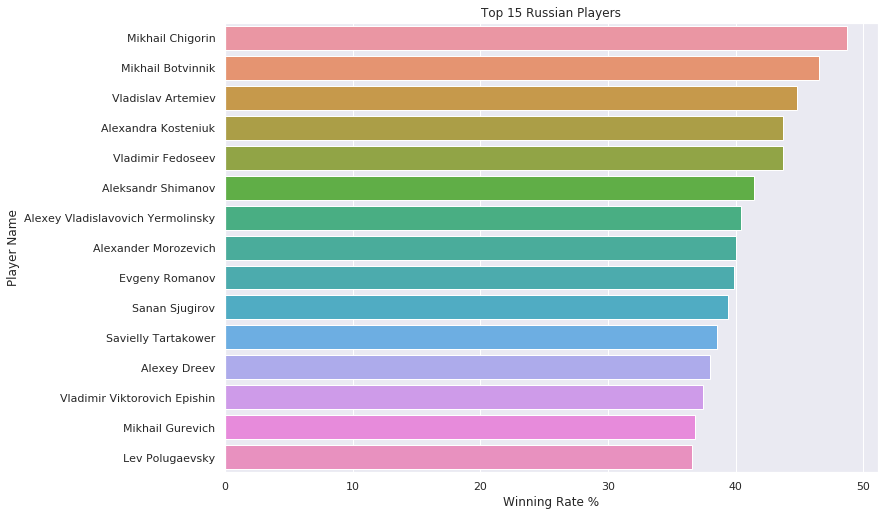

In [547]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(y=dfRussianGameplot['FLName'],
                 x=dfRussianGameplot['WinRate'])
ax.set_ylabel('Player Name')
ax.set_title('Top 15 Russian Players')
ax.set_xlabel('Winning Rate %');

##### Top Three Russians player based on their total moves

In [655]:
names = dfRussianGameplot['FLName'].head(3).tolist()

In [656]:
dfRussia3 = dfRussia[dfRussia['FLName'].isin(names)] 

In [658]:
dfRussia3moves = dfRussia3.groupby(['FLName','Year'])['Moves'].sum().to_frame()
dfRussia3moves = dfRussia3moves.reset_index()

In [697]:
dfRussia3games = dfRussia3.groupby(['FLName','Year'])['Moves'].count().to_frame()
dfRussia3games = dfRussia3games.reset_index()

In [698]:
dfRussia3_1 = dfRussia3moves.merge(dfRussia3games,right_on=['FLName','Year'],
                                  left_on=['FLName','Year'])

In [699]:
cols3=['Name','Year','Moves','TotalGames']
dfRussia3_1.rename(columns=dict(zip(dfRussia3_1,cols3)),inplace=True)

In [700]:
dfRussia3_1.loc[:,'AverageMove'] = ((dfRussia3_1['Moves']/dfRussia3_1['TotalGames'])).round(2)

In [702]:
dfRussia3_1 = dfRussia3_1.pivot(index='Year', columns='Name',values='AverageMove').fillna(0)

In [703]:
dfRussia3_1 = dfRussia3_1.reset_index()

In [670]:
dfRussia3a = dfRussia3_1[['Year','Mikhail Botvinnik']]
dfRussia3b = dfRussia3_1[['Year','Mikhail Chigorin']]
dfRussia3c = dfRussia3_1[['Year','Vladislav Artemiev']]

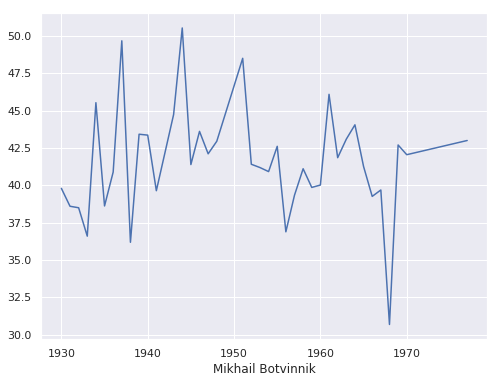

In [715]:
dfRussia3a = dfRussia3a.replace(0,np.nan).dropna(axis=1,how="all")
fig1 = plt.figure(figsize=(8,6))
ax2 = fig1.add_subplot(111)
ax2.plot(dfRussia3a['Year'],dfRussia3a['Mikhail Botvinnik']);
ax2.set_xlabel('Mikhail Botvinnik');

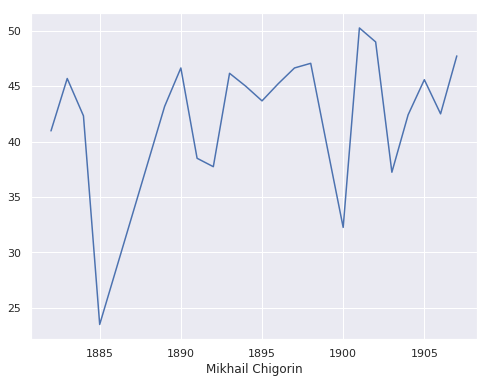

In [713]:
dfRussia3b = dfRussia3b.replace(0,np.nan).dropna(axis=1,how="all")
fig1 = plt.figure(figsize=(8,6))
ax3 = fig1.add_subplot(111)
ax3.plot(dfRussia3b['Year'],dfRussia3b['Mikhail Chigorin']);
ax3.set_xlabel('Mikhail Chigorin');

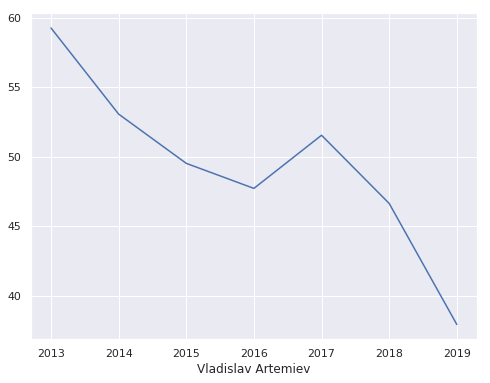

In [718]:
dfRussia3c = dfRussia3c.replace(0,np.nan).dropna(axis=1,how="all")
fig1 = plt.figure(figsize=(8,6))
ax2 = fig1.add_subplot(111)
ax2.plot(dfRussia3c['Year'],dfRussia3c['Vladislav Artemiev']);
ax2.set_xlabel('Vladislav Artemiev');

##### Key Insight on Top 3 Grandmasters?

`Mikhail Botvinnik` is able to maintain his reputation primarily due to the fact the his total number of moves in his career have been under the distribution of winning range move. Similar can be said for other Grandmaster.

## VI. Conclusion/Recommendations

#### 1. Conclusions
1. Russia dominates the throne of Chess. The Soviet Union had a lot of institutional support. The state sponsored clubs, trainers, coaches, and first rate tournaments. There were a number of state entities that sponsored chess. Trade unions, the military, and constituent states supported much of the chess infrastructure. But the overall chess population supported a very rigorous rating system. Even today, most of the domimnating chess grandmasters hail from Russia

2. Globally, if we inspect, Winning Rate is 37% as mentioned earlier. By inspecting the top 15 grandmasters of Chess, we can see that most of the Russians have winning rate more than 40%, which is exceptionally high comapred to other nations.

#### 2. Recommendations:
With more datapoints like FIDE ratings and ELO ratings, a correlation between moves, winrates and the mentioned metrics can tell us a lot more about the internal logic underlying in this game of logic.

## VII. References
https://en.wikipedia.org/wiki/Chessgames.com

https://en.wikipedia.org/wiki/Beautiful_Soup_(HTML_parser)

https://docs.python.org/2/library/sqlite3.html

## VIII. Acknowledgements
* Prof. Christian Alis
* Prof. Eduardo David
* ACCeSs Lab Team
* Asian Institute of Management